# Korean News Summary Model

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 169kB/s 
     |████████████████████████████████| 460kB 47.0MB/s 
     |████████████████████████████████| 92kB 13.5MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import tensorflow as tf
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

## Data

In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Reviews.csv 파일을 data라는 이름의 데이터프레임에 저장. 단, 10만개의 행(rows)으로 제한.
data = pd.read_excel("/content/drive/MyDrive/종합 텍스트.xlsx")
print('전체 뉴스 개수 :',(len(data)))

전체 뉴스 개수 : 16983


In [ ]:
data.head()

,기사번호,기사카테고리,매체유형,매체구분,매체명,기사대중소,기사본문글자수,발행일시,제목,내용,가독성,정확성,정보성,신뢰성,생성,추출1,추출2,추출3
0,371224146,종합,online,지역지,기호일보,medium,1436,2019-12-18 00:00:00,수사권 조정은 국민인권의 첫걸음,기호일보\n\n전영태 안산단원경찰서 112종합상황실/경위\n전영태 안산단원경찰서 1...,4,4,3,4,현 정부의 핵심 과제인 검경 수사권 조정의 핵심은 검찰의 막강한 권한을 분산해 권력...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.,형사 사법제도의 본질은 경찰·검찰·법원 등 삼권 분립으로 상호 견제와 균형을 이뤄 ...,이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 타 기관과의 상호 감시와 견...
1,363331583,종합,online,지역지,기호일보,small,898,2019-10-16 00:00:00,인천서 외래 해충 ‘소나무허리노린재’ 발생,최유탁 기자\n\n인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인\n임업...,4,4,4,4,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단'이 월미도와 인천대학...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...,15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는...,국내에서 발생이 확대될 경우 침엽수 비중이 높은 산림생태계 및 가평 등지의 잣 생산...
2,363195607,종합,online,지역지,기호일보,small,747,2019-10-15 00:00:00,"김상희 의원 ""심평원 보험사기 방지 업무 민간 보험사 배불려""",최두환 기자\n\n건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 ...,4,5,4,4,더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,더불어민주당 김상희(부천 소사) 국회원이 건강보험공단에서 확인한 자료에 따르면 심평...,문제는 이 돈이 건강보험 재정에서 나온다는 것이다.
3,357571415,종합,online,지역지,기호일보,small,757,2019-08-27 00:00:00,"부천시, ‘포도 수확 체험 프로그램’ 운영",부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,3,3,3,3,부천시는 포도를 수확하고 맛도 볼 수 있으며 수확한 포도(5kg)을 가져갈 수 있는...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,"가족 체험에 참여하면 포도 수확, 포도 맛보기 체험을 하고 수확한 포도(5㎏)를 가...","시 관계자는 ""도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소..."
4,368209875,종합,online,지역지,기호일보,small,767,2019-11-23 13:10:55,"가평군지사협, 어르신 짝쿵 초청 ‘힐링 문화소풍!’",엄건섭 기자\n\n가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신...,5,4,4,4,가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,23일 가평읍에 따르면 ‘힐링 문화소풍!’은 복지사각지대에 있는 지역 어르신들을 대...,"내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 기회를 제공하도록 하겠다""라..."


In [ ]:
data = data[['내용','추출1', '추출2', '추출3']]
data.head()

,내용,추출1,추출2,추출3
0,기호일보\n\n전영태 안산단원경찰서 112종합상황실/경위\n전영태 안산단원경찰서 1...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.,형사 사법제도의 본질은 경찰·검찰·법원 등 삼권 분립으로 상호 견제와 균형을 이뤄 ...,이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 타 기관과의 상호 감시와 견...
1,최유탁 기자\n\n인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인\n임업...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...,15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는...,국내에서 발생이 확대될 경우 침엽수 비중이 높은 산림생태계 및 가평 등지의 잣 생산...
2,최두환 기자\n\n건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 ...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,더불어민주당 김상희(부천 소사) 국회원이 건강보험공단에서 확인한 자료에 따르면 심평...,문제는 이 돈이 건강보험 재정에서 나온다는 것이다.
3,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,"가족 체험에 참여하면 포도 수확, 포도 맛보기 체험을 하고 수확한 포도(5㎏)를 가...","시 관계자는 ""도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소..."
4,엄건섭 기자\n\n가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,23일 가평읍에 따르면 ‘힐링 문화소풍!’은 복지사각지대에 있는 지역 어르신들을 대...,"내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 기회를 제공하도록 하겠다""라..."


In [ ]:
data['생성2'] = data[['추출1', '추출2']].apply(lambda x: ':'.join(x), axis=1)

In [ ]:
data.head()

,내용,추출1,추출2,추출3,생성2
0,기호일보\n\n전영태 안산단원경찰서 112종합상황실/경위\n전영태 안산단원경찰서 1...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.,형사 사법제도의 본질은 경찰·검찰·법원 등 삼권 분립으로 상호 견제와 균형을 이뤄 ...,이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 타 기관과의 상호 감시와 견...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.:형사 사법제도의 본질은 ...
1,최유탁 기자\n\n인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인\n임업...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...,15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는...,국내에서 발생이 확대될 경우 침엽수 비중이 높은 산림생태계 및 가평 등지의 잣 생산...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...
2,최두환 기자\n\n건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 ...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,더불어민주당 김상희(부천 소사) 국회원이 건강보험공단에서 확인한 자료에 따르면 심평...,문제는 이 돈이 건강보험 재정에서 나온다는 것이다.,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...
3,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,"가족 체험에 참여하면 포도 수확, 포도 맛보기 체험을 하고 수확한 포도(5㎏)를 가...","시 관계자는 ""도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소...",부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...
4,엄건섭 기자\n\n가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,23일 가평읍에 따르면 ‘힐링 문화소풍!’은 복지사각지대에 있는 지역 어르신들을 대...,"내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 기회를 제공하도록 하겠다""라...",가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...


In [ ]:
data.dropna(axis=0, inplace=True)
data.shape

(16974, 5)

In [ ]:
data['생성'] = data[['생성2', '추출3']].apply(lambda x: ':'.join(x), axis=1)
data.head()

,내용,추출1,추출2,추출3,생성2,생성
0,기호일보\n\n전영태 안산단원경찰서 112종합상황실/경위\n전영태 안산단원경찰서 1...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.,형사 사법제도의 본질은 경찰·검찰·법원 등 삼권 분립으로 상호 견제와 균형을 이뤄 ...,이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 타 기관과의 상호 감시와 견...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.:형사 사법제도의 본질은 ...,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.:형사 사법제도의 본질은 ...
1,최유탁 기자\n\n인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인\n임업...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...,15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는...,국내에서 발생이 확대될 경우 침엽수 비중이 높은 산림생태계 및 가평 등지의 잣 생산...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...
2,최두환 기자\n\n건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 ...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,더불어민주당 김상희(부천 소사) 국회원이 건강보험공단에서 확인한 자료에 따르면 심평...,문제는 이 돈이 건강보험 재정에서 나온다는 것이다.,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...
3,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,"가족 체험에 참여하면 포도 수확, 포도 맛보기 체험을 하고 수확한 포도(5㎏)를 가...","시 관계자는 ""도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소...",부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...
4,엄건섭 기자\n\n가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,23일 가평읍에 따르면 ‘힐링 문화소풍!’은 복지사각지대에 있는 지역 어르신들을 대...,"내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 기회를 제공하도록 하겠다""라...",가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...


In [ ]:
del data["추출1"]
del data["추출2"]
del data["추출3"]
del data["생성2"]
data.shape

(16974, 2)

## Preprocessing

In [ ]:
print('내용 열에서 중복을 배제한 유일한 샘플의 수 :', data['내용'].nunique())
print('생성 열에서 중복을 배제한 유일한 샘플의 수 :', data['생성'].nunique())

내용 열에서 중복을 배제한 유일한 샘플의 수 : 16973
생성 열에서 중복을 배제한 유일한 샘플의 수 : 16973


In [ ]:
# text 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['내용'], inplace=True)
print("전체 샘플수 :", len(data))

전체 샘플수 : 16973


In [ ]:
print(data.isnull().sum())

내용    0
생성    0
dtype: int64


In [ ]:
# Null 값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 16973


In [ ]:
i = 0
# 이메일 기자 이름 제거
for s in data['내용']:
  data['내용'][i] = s[0:-30]
  i = i + 1

In [ ]:
# 한글 불용어
stopword = pd.read_csv('/content/drive/MyDrive/한국어불용어100.txt', sep = "\t", encoding = "utf-8", header=None)
stopword.loc[100] = ['기자', 'VX', 0.000483]
stop_words =  set(stopword[0])
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 95
{'받', '소리', '원', '많', '앞', '어떤', '점', '기자', '자신', '문제', '씨', '사실', '싶', '있', '따르', '시키', '나오', '통하', '개', '중', '정도', '월', '이런', '시간', '더', '우리', '말', '못하', '잘', '경우', '없', '때', '같', '그', '보', '지', '그러', '알', '오', '말하', '내', '주', '명', '그것', '지금', '한', '하', '만들', '살', '생각하', '하나', '그리고', '놓', '두', '위하', '그녀', '대하', '그렇', '어떻', '가지', '적', '안', '번', '보이', '크', '데', '여자', '않', '등', '좋', '다른', '가', '모르', '그러나', '되', '집', '좀', '다시', '이렇', '이', '때문', '생각', '속', '년', '또', '것', '나', '들', '일', '아니', '전', '수', '그런', '사람', '사회'}


In [ ]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub(r"▲\a","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[.,!?\"':;~()]", " ", sentence) # 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("r'[^ ㄱ-ㅣ가-힣A-Za-z]", " ", sentence)

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought was great infact ordered twice and the third ordered wasfor my mother and father
great way to start the day


In [ ]:
# Text 열 전처리
clean_text = []
for s in data['내용']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['기호일보 전영태 안산단원경찰서 112종합상황실/경위 전영태 안산단원경찰서 112종합상황실 검경 수사권 개혁에 대한 문제는 정부의 핵심 과제이다 대통령의 사법농단을 수사하느라 사법개혁특별위원회 구성이 늦어져 최근에 논의되고 있다 수사권 조정 지연은 제1야당의 소위원회 구성 비협조와 검찰의 미온적 태도로 현재까지 협상 중이다 그래서 대통령과 4당의 당대표 국회의원들이 수사권 조정을 통해 국민의 인권을 증진하고 검찰 권력의 폐해를 예방해 제왕적 권력을 분산하자는 것이다 그런데 검찰은 최근에 공수처법과 검경 수사권 조정안 등이 포함된 ‘패스트 트랙’ 국회 본회의 처리가 임박하자 검찰 간부들이 여야 의원을 불문하고 개별 접촉해 검찰개혁 법안 수정에 총력을 기울이는 것으로 알려졌다 고사성어 득롱망촉이라는 말이 있다 인간의 욕심은 한이 없어 권력에 한번 중독이 되면 마약과 같아서 끊임없이 쟁취하고 자신의 것을 지키기 위해 사람과도 타협하지 않는다고 한다 지금의 검찰이 그렇다 중국의 시진핑은 권력은 부패를 초래하고 절대 권력은 반드시 부패한다 라고 말했고 다산 정약용도 나라를 망하게 하는 것은 외침이 아니라 권력의 부정부패에 의한 민심의 이반이라고 경고했다 검찰의 모습은 한마디로 우이독경이다 국민의 대표인 국회의원과 대통령이 신속처리법안 개정의 보완이 필요하다고 하는데 검찰만이 아니라고 얘기하는 모습이 너무나 안쓰럽다 최근 검찰개혁에 대한 국민의 여론조사와 5월에 발간한 백년하청 검찰개혁 보고서에 의하면 검찰을 개혁해야 한다는 여론이 75% 이상 나왔다 이번에도 검찰개혁이 무산되면 무소불위의 검찰 공화국이 것이다 우리는 노무현 정부의 검찰과의 토론회나 정부의 수사권 조정 과정에서 검찰이 얼마나 힘이 센지 여실히 보았다 형사 사법제도의 본질은 경찰·검찰·법원 삼권 분립으로 상호 견제와 균형을 이뤄 대등한 관계에서 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다 하지만 우리의 현실은 검찰이 수사권 수사 지휘권 수사 종결권 영장 청구권 제왕적 권한을 갖고 있어 권력

In [ ]:
# Summary 열 전처리
clean_summary = []
for s in data['생성']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

['검경 수사권 개혁에 대한 문제는 정부의 핵심 과제이다 형사 사법제도의 본질은 경찰·검찰·법원 삼권 분립으로 상호 견제와 균형을 이뤄 대등한 관계에서 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다 이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 기관과의 상호 감시와 견제를 통해 국민의 인권을 증진하자는 것이다',
 '임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 ‘소나무허리노린재’가 인천지역 공원과 산림에서 확인했다 15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는 월미도와 인천대학교 송도캠퍼스 등에서 정착한 개체군을 확인했다 국내에서 발생이 확대될 경우 침엽수 비중이 높은 산림생태계 가평 등지의 생산에 심각한 피해가 예상된다',
 '건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 따른 심평원 설립 취지를 훼손시키고 있다는 지적이 대두됐다 더불어민주당 김상희 국회원이 건강보험공단에서 확인한 자료에 따르면 심평원은 2015년 이전부터 수사기관에서 의뢰가 들어오면 간간히 지원업무를 해오다 2015년 1월부터 전담부서인 공공심사부를 설치했으며 2016년 ‘보험사기방지 특별법’이 제정되면서 법에 따라 공식적으로 입원적정성 심사 업무를 수행해 왔다 문제는 돈이 건강보험 재정에서 나온다는 것이다',
 '부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 운영한다고 26일 밝혔다 가족 체험에 참여하면 포도 수확 포도 맛보기 체험을 하고 수확한 포도를 가져갈 있다 관계자는 도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소중한 추억이 것이라며 시민들이 우리 지역의 농업과 농촌을 이해하고 농산물을 믿고 구입하는 기회가 되길 바란다고 말했다',
 '가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 문화소풍’을 올해 마지막으로 추진했다 2

In [ ]:
data['내용'] = clean_text
data['생성'] = clean_summary

In [ ]:
# 길이가 공백인 샘플은 NULL 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

내용    0
생성    0
dtype: int64


In [ ]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 16973


텍스트의 최소 길이 : 6
텍스트의 최대 길이 : 443
텍스트의 평균 길이 : 199.94385200023567
요약의 최소 길이 : 9
요약의 최대 길이 : 171
요약의 평균 길이 : 53.35674306251105


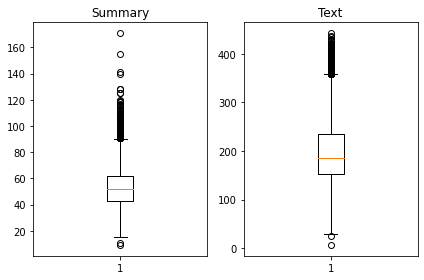

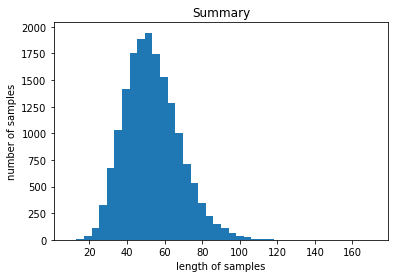

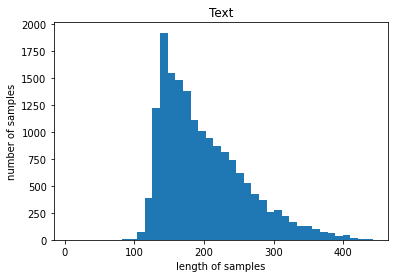

In [ ]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['내용']]
summary_len = [len(s.split()) for s in data['생성']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
text_max_len = 300
summary_max_len = 60

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
below_threshold_len(text_max_len, data['내용'])

전체 샘플 중 길이가 300 이하인 샘플의 비율: 0.9253520296942203


In [ ]:
below_threshold_len(summary_max_len, data['생성'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.7128380368821069


In [ ]:
data = data[data['내용'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['생성'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 11158


In [ ]:
data.head()

,내용,생성
0,기호일보 전영태 안산단원경찰서 112종합상황실/경위 전영태 안산단원경찰서 112종합...,검경 수사권 개혁에 대한 문제는 정부의 핵심 과제이다 형사 사법제도의 본질은 경찰·...
1,최유탁 인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인 임업진흥원 외래 ...,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을...
2,최두환 건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...
3,부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 ...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...
4,엄건섭 가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...


In [ ]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['내용'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['생성'].apply(lambda x : x + ' eostoken')
data.head()

,내용,생성,decoder_input,decoder_target
0,기호일보 전영태 안산단원경찰서 112종합상황실/경위 전영태 안산단원경찰서 112종합...,검경 수사권 개혁에 대한 문제는 정부의 핵심 과제이다 형사 사법제도의 본질은 경찰·...,sostoken 기호일보 전영태 안산단원경찰서 112종합상황실/경위 전영태 안산단원...,검경 수사권 개혁에 대한 문제는 정부의 핵심 과제이다 형사 사법제도의 본질은 경찰·...
1,최유탁 인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인 임업진흥원 외래 ...,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을...,sostoken 최유탁 인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인 ...,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을...
2,최두환 건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,sostoken 최두환 건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 ...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...
3,부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 ...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,sostoken 부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...
4,엄건섭 가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,sostoken 엄건섭 가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...


In [ ]:
encoder_input = np.array(data['내용'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [ ]:
data.head()

,내용,생성,decoder_input,decoder_target
0,기호일보 전영태 안산단원경찰서 112종합상황실/경위 전영태 안산단원경찰서 112종합...,검경 수사권 개혁에 대한 문제는 정부의 핵심 과제이다 형사 사법제도의 본질은 경찰·...,sostoken 기호일보 전영태 안산단원경찰서 112종합상황실/경위 전영태 안산단원...,검경 수사권 개혁에 대한 문제는 정부의 핵심 과제이다 형사 사법제도의 본질은 경찰·...
1,최유탁 인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인 임업진흥원 외래 ...,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을...,sostoken 최유탁 인천대 배양섭 교수 월미도·인천대 송도캠 정착 개체군 확인 ...,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을...
2,최두환 건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...,sostoken 최두환 건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 ...,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...
3,부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 ...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...,sostoken 부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체...,부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...
4,엄건섭 가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...,sostoken 엄건섭 가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘...,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...


## Split Data

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[11149  7292 10304 ...  9845 10799  2732]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 2231


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 8927
훈련 레이블의 개수 : 8927
테스트 데이터의 개수 : 2231
테스트 레이블의 개수 : 2231


## Encoding

In [ ]:
encoder_input_train

array(['강나리 수성구의회 촉구 결의안 채택 국토부·대구시에 전달 방침 대구 수성구의회가 도시공원을 살리기 위한 대책 마련을 국토교통부와 대구시에 촉구하는 결의안을 채택했다 수성구의회는 24일 열린 제230회 제1차 정례회 제3차 본회의에서 전영태 의원이 대표 발의한 ‘대구시 수성구 도시공원 살리기 촉구 결의안’을 상정하고 전체 의원 20명 만장일치로 채택했다고 밝혔다 수성구의회는 결의문을 통해 “2000년 7월 도시계획시설로 지정된 공원들에 대해 내년 6월 말까지 대구시가 부지를 매입하지 않을 공원 지정이 일괄적으로 해제되는 공원 일몰제가 시행된다 내년 7월 1일 사라질 도시공원은 대구시 관내에는 38곳 20곳이며 수성구 관내에는 범어공원 4곳이다”며 “일몰제 시행에도 불구하고 대구시와 수성구는 재정적 여건만을 이유로 아직까지 책임 있는 대책을 마련하지 못했다”고 지적했다 그러면서 “일몰 위기에 빠진 도시공원에 대해 중앙정부는 도시공원 사무가 지방자치단체의 고유 책임이라며 일체의 재정 행정 지원을 하지 않고 있다”고 덧붙였다 수성구의회는 △국토부가 도시공원 토지매입비 확보가 어려운 지방자치단체에 예산을 지원하고 도시공원 국공유지를 일몰제에서 제외할 △2005년 개정된 ‘도시자연공원구역’ 제도를 새롭게 정비해 일몰제를 맞는 모든 도시공원들에 대한 대책을 조속히 마련할 △도시공원을 자연환경 보전과 도시민의 여가 이용에 기여할 있도록 자연 그대로 보존할 등을 촉구할 예정이다 채택된 결의안은 국토부와 대구시 관련 기관에 전달할',
       '임소연 현대차 여의도 국회에 도심형 수소충전소 착공 오는 8월 완공 예정…1천236 3㎡ 규모 연중무휴 운영…하루 70대 차량 충전 가능 30일 서울 여의도 국회에서 열린 국회 수소충전소 착공식에서 왼쪽부터 수소에너지네트워크 유종수 대표 중소벤처기업부 박영선 장관 더불어민주당 김영춘 의원 자유한국당 이종배 의원 국회 산업통상자원중소벤처기업위원회 홍일표 위원장 더불어민주당 홍의락 의원 유인태 국회사무총장 산업통상자원부 성

In [ ]:
from konlpy.tag import Okt
okt = Okt()
# encoder_input_train = encoder_input_train.apply(lambda x : okt.morphs(x))

AttributeError: ignored

In [ ]:
from konlpy.tag import Okt
from tqdm import tqdm
okt = Okt()
encoder_input_train_tok = np.empty((1,))
for s in tqdm(encoder_input_train):
  encoder_input_train_tok = np.append(encoder_input_train_tok, okt.morphs(s), axis=0)

100%|██████████| 8927/8927 [20:34<00:00,  7.23it/s]


In [ ]:
encoder_input_train_tok

array(['1.35e-320', '강', '나리', ..., '전정훈', 'jjhun', '@'], dtype='<U32')

In [ ]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [ ]:
encoder_input_train_tok.shape[0]

3121544

In [ ]:
threshold = 4
total_cnt = encoder_input_train_tok.shape[0] # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for value in encoder_input_train_tok:
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

TypeError: ignored

In [ ]:
src_vocab = 50000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [ ]:
print(encoder_input_train[:3])

[[6521, 1188, 17057, 10532, 1724, 6522, 132, 6345, 6, 910, 1535, 5373, 7699, 3592, 13907, 7700, 283, 58, 4217, 4047, 4787, 2958, 748, 125, 4048, 12337, 5115, 11631, 6345, 1188, 21945, 154, 431, 8604, 12338, 43581, 12, 10083, 4, 151, 31131, 1725, 24, 82, 141, 827, 3517, 1867, 644, 1708, 10084, 13908, 1708, 7701, 82, 151, 228, 21946, 911, 5115, 27351, 1065, 3379, 13909, 574, 4424, 3081, 2, 821, 17058, 20012, 514, 610, 3968, 4519, 24, 11631, 8605, 10085, 18423, 1099, 1603, 134, 523, 105, 357, 472, 11631, 31132, 6154, 237, 20013, 509, 576, 11631, 4308, 1709, 539, 13910, 335, 86, 8, 821, 1926, 1868, 14839, 20014, 36334, 10533, 6523, 797, 16, 2899, 1151, 43582, 13, 17059, 23, 9249, 20015, 13048, 911, 28, 4309, 3082], [400, 5374, 4654, 2855, 21947, 7429, 3083, 31, 153, 5811, 31133, 1088, 17060, 11051, 484, 6947, 2223, 250, 119, 4654, 1325, 58, 221, 7429, 8920, 125, 6948, 12339, 997, 557, 31134, 431, 769, 431, 221, 43583, 31135, 3320, 557, 27352, 431, 4788, 27353, 997, 7987, 1903, 41, 43584, 1

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 355679
등장 빈도가 3번 이하인 희귀 단어의 수: 300743
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 54936
단어 집합에서 희귀 단어의 비율: 84.55461244549159
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 22.85331021474513


In [ ]:
tar_vocab = 50000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [ ]:
print(decoder_input_train[:5])

[[4, 7451, 1266, 19477, 12555, 1918, 7452, 122, 6398, 8, 859, 1526, 5224, 6573, 3326, 14438, 7077, 181, 56, 3703, 3704, 4404, 2635, 716, 123, 3474, 13746, 5131, 14439, 6398, 1266, 22496, 160, 453, 8104, 12013, 37961, 9, 10974, 6, 145, 24455, 1660, 26, 73, 137, 799, 2929, 1848, 717, 1734, 8579, 17082, 44254, 1734, 6901, 73, 145, 177, 20863, 960, 5131, 33287, 1103, 3017, 14440, 591, 4478, 3181, 2, 831, 16151, 22497, 578, 704, 3790, 4578, 26, 14439, 8105, 10975, 20864, 1117, 1601, 141, 542, 111, 417, 547, 14439, 37962, 6088, 283, 19478, 501, 625, 14439, 4674, 1813, 489, 13747, 352, 92, 11, 831, 2225, 1919, 14441, 20865, 37963, 12014, 6902, 852, 19, 2636, 1211, 15, 18203, 24, 9819, 22498, 13748, 960, 28, 4932, 3103], [4, 541, 6574, 4326, 2733, 24456, 7453, 3140, 22, 142, 6903, 33288, 1080, 19479, 10976, 525, 8106, 2436, 174, 117, 4326, 1242, 56, 215, 7453, 10977, 123, 6904, 13132, 961, 526, 33289, 453, 624, 453, 215, 37964, 37965, 3226, 526, 33290, 453, 4675, 24457, 961, 8869, 2201, 44, 1,

In [ ]:
print(decoder_target_train[:5])

[[199, 42, 740, 914, 9800, 20578, 1359, 46109, 48316, 694, 21, 1048, 8631, 44534, 9872, 2898, 110, 1482, 5], [211, 17, 24638, 15997, 8095, 1141, 228, 42, 1926, 300, 1776, 309, 3083, 6280, 231, 1425, 42124, 226, 21, 42, 2757, 49605, 254, 11396, 1166, 683, 6378, 55, 28337, 1002, 727, 24, 2729, 38527, 9021, 21, 42, 2723, 4436, 254, 2727, 13883, 13273, 1808, 1669, 5210, 37, 5], [17390, 22, 3508, 5878, 19978, 1810, 897, 263, 101, 452, 4778, 15532, 27215, 16, 6154, 3077, 5752, 2365, 58, 113, 38470, 1919, 19, 337, 481, 17682, 16259, 49, 36861, 50, 10273, 4156, 22865, 5221, 2, 44992, 12209, 1692, 660, 2432, 1876, 224, 26143, 45, 5], [3433, 36498, 1873, 722, 38425, 95, 1735, 10, 5740, 48182, 17, 7, 482, 305, 10674, 36498, 29970, 1466, 454, 10493, 29973, 4866, 1550, 159, 1, 22110, 38425, 11023, 41856, 29973, 24266, 193, 38423, 15953, 5], [1350, 1350, 10704, 87, 15783, 1, 1350, 19113, 3160, 49227, 1874, 87, 27777, 23328, 313, 1240, 813, 7693, 10300, 30033, 2286, 1669, 12624, 21252, 18539, 517, 72

## Remove Empty Samples

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [ ]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [ ]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 8927
훈련 레이블의 개수 : 8927
테스트 데이터의 개수 : 2231
테스트 레이블의 개수 : 2231


## Padding

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## Seq2Seq + Attention Summary Model

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 300, 128)     6400000     input_13[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 300, 256), ( 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
______________________________________________________________________________________

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 300, 128)     6400000     input_13[0][0]                   
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 300, 256), ( 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
______________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 32, callbacks=[es], epochs = 20)

Epoch 1/20
279/279 [==============================] - 1007s 4s/step - loss: 6.1816 - val_loss: 5.7932
Epoch 2/20
279/279 [==============================] - 1004s 4s/step - loss: 5.9237 - val_loss: 5.9227
Epoch 3/20
279/279 [==============================] - 1004s 4s/step - loss: 5.8385 - val_loss: 5.8447
Epoch 4/20
279/279 [==============================] - 1005s 4s/step - loss: 5.7729 - val_loss: 5.8635
Epoch 5/20
279/279 [==============================] - 1007s 4s/step - loss: 5.6950 - val_loss: 5.9991
Epoch 6/20
279/279 [==============================] - 1006s 4s/step - loss: 5.6458 - val_loss: 5.9444
Epoch 00006: early stopping


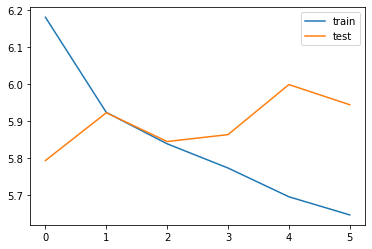

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluation

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [ ]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index != 0:
          sampled_token = tar_index_to_word[sampled_token_index]
        else:
          sampled_token = 'eostoken'

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(500, 510):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  이은창 낡은 학교 새긴 섬마을 아이들 여수 전교생 3일간 벽화 작업 전남 여수 학생들이 낡은 자신들의 꿈을 그린 그림으로 꾸몄다 전남도교육청 제공 바닷가 낡은 학교 건물 아이들의 꿈을 담은 아름다운 여수 전교생 8명은 최근 활동의 일환으로 교사와 함께 닮은 우리들의 완성했다 학생들이 중심이 추진한 벽화 동시에 이뤄졌다 주제로 아이들의 생각과 아름다운 세상을 표현했다 상징인 백야 바다 아이들의 모습을 그렸다 작업은 전교생 교직원들이 함께 동안 진행했다 학생들은 교내 다목적실에서 그림을 그린 전문가의 자문을 받아 벽에 그림 부착했다 벽화 전교생 8명과 교직원 학부모들이 함께 참여해 3일 동안 직접 그림을 작업을 했다 지난 4월 구상을 별로 작업을 진행했다 이번 통해 낡고 오래 미관을 학교 건물의 산뜻하게 작업 과정에서 간의 선후배 친구와 협력과 배려를 배우는 의미있는 시간도 가졌다 교사는 “학생들이 자신의 손으로 학교를 아름답게 꾸밀 있어 자부심을 가졌고 학교 사랑과 자랑스럽게 생각하는 갖게 됐다”고 말했다 6학년 예쁘게 바뀌어 학교에 오는 것이 소감을 밝혔다 교장은 통해 학생과 교직원 아니라 지역주민들에게 새로운 감성과 주고 있어 앞으로도 지속적으로 아름다운 교육 공간을 만들기 위해 노력하겠다”고 말했다 이은창 lec namdonews 
실제 요약문 : 과정에서 사제 간의 선후배 친밀감 친구와 협력과 배려를 배우는 의미있는 시간도 가졌다 교사는 “학생들이 자신의 손으로 학교를 아름답게 꾸밀 있어 자부심을 가졌고 학교 사랑과 자랑스럽게 생각하는 갖게 됐다”고 말했다 6학년 예쁘게 바뀌어 학교에 오는 것이 소감을 밝혔다 교장은 통해 학생과 교직원 아니라 지역주민들에게 새로운 감성과 행복감을 주고 있어 앞으로도 지속적으로 아름다운 교육 공간을 만들기 위해 노력하겠다”고 말했다 이은창 lec namdonews 
예측 요약문 :  전남 지난 따르면 위해 위해 위해 위해 밝혔다 밝혔다 밝혔다 밝혔다 밝혔다 밝혔다 밝혔다 밝혔다 밝혔다 밝혔다 밝혔다 밝혔다 밝혔다